In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

# loading precomputed matrices for testing
# (prepared by the camera_calibration.ipynb script)
pickle_in = open("calibration_mat.pickle","rb")
calibration_mat_2 = pickle.load(pickle_in)

In [41]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Four source cordinates
src = np.float32(
    [[254, 700],
     [595, 449],
     [688, 448],
     [1062, 693]
    ])
# Four desired cordinates
dst = np.float32(
    [[254, 700],
     [254, 0],
     [1062, 0],
     [1061, 693]
    ])

Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)

def warp(img, src, dst, M=None):   
    img_size = (img.shape[1], img.shape[0])
    if M is None: M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst, Minv=None):
    img_size = (img.shape[1], img.shape[0])
    if Minv is None: Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

PREV_leftx_base = None
PREV_rightx_base = None

def detect_lane(binary_warped):
    global PREV_leftx_base
    global PREV_rightx_base
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    if PREV_leftx_base is None:
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    else:
        leftx_base = PREV_leftx_base
        rightx_base = PREV_rightx_base

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if window == 0: #update previous base
            PREV_rightx_base = rightx_current
            PREV_leftx_base = leftx_current
                        

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

def get_curvature(left_fit, right_fit, leftx, lefty, rightx, righty, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #return left_curverad, right_curverad
    return 'Radius of Curvature: %.1fm '%(max(left_curverad, right_curverad))

def get_position(left_fit, right_fit, binary_warped):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Detect vehicle po sition: assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for.
    mid_lane = (left_fitx[-1] + right_fitx[-1])/2
    deviation_pixels = mid_lane - 1280/2
    deviation_mettres = deviation_pixels * xm_per_pix

    if deviation_mettres > 0 :
        position_str = 'Vehicle is %.2fm left of center'%abs(deviation_mettres)
    else:
        position_str = 'Vehicle is %.2fm right of center'%abs(deviation_mettres)
    return position_str

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
import pdb
def process_image(image):
    global calibration_mat_2
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    undistorted_img = cv2.undistort(image, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])
    combined_binary = pipeline(undistorted_img)
    
    imshape = combined_binary.shape
    X = imshape[1]
    Y = imshape[0]
    
    #Define a region of interest
    vertices = np.array([[(0,Y),(0.45*X, 0.55*Y), (0.55*X, 0.55*Y), (X,Y)]], dtype=np.int32)
    selected_img = region_of_interest(combined_binary, vertices)
    
    global M
    binary_warped = warp(selected_img, None, None, M)

    left_fit, right_fit, leftx, lefty, rightx, righty = detect_lane(binary_warped)

    # Create an image to draw the lines on
    warped = binary_warped
    warp_zero = np.zeros((warped.shape[0], warped.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))
    
    #cv2.polylines(color_warp,np.int32([pts_left]),True,(255,0,0), thickness=15)
    #cv2.polylines(color_warp,np.int32([pts_right]),True,(0,0,255), thickness=15)
    pts_left = np.int32(pts_left)
    pts_right = np.int32(pts_right)
    
    #pdb.set_trace()
    for i in range(len(pts_left[0])-1):
        cv2.line(color_warp,totuple(pts_left[0][i]),totuple(pts_left[0][i+1]),(255,0,0),25)
        cv2.line(color_warp,totuple(pts_right[0][i]),totuple(pts_right[0][i+1]),(0,0,255),25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.5, 0)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(result,'%s %s'%(get_curvature(left_fit, right_fit, leftx, lefty, rightx, righty, binary_warped),
                                get_position(left_fit, right_fit, binary_warped)),
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    return result

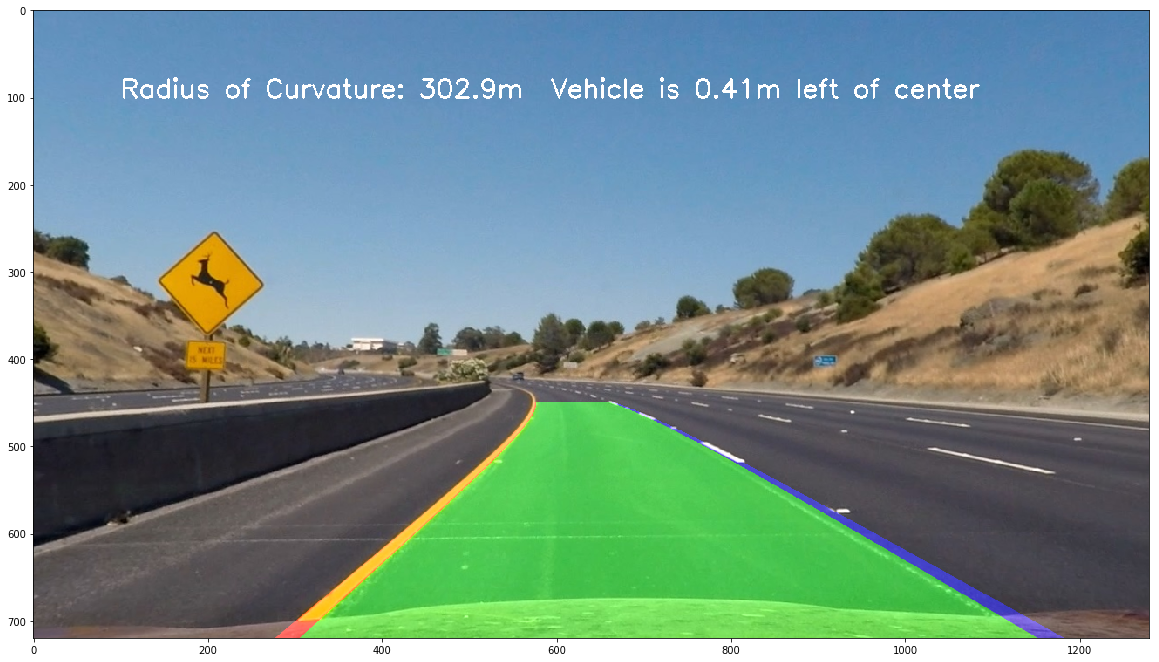

In [42]:
fname = 'test_images/test2.jpg'
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = process_image(img)
plt.figure(figsize=(20,20))
plt.imshow(img)


In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_proccessed.mp4
[MoviePy] Writing video ./project_video_proccessed.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<02:25,  8.62it/s]

  0%|          | 4/1261 [00:00<02:07,  9.87it/s]

  0%|          | 6/1261 [00:00<02:00, 10.45it/s]

  1%|          | 8/1261 [00:00<02:00, 10.43it/s]

  1%|          | 10/1261 [00:00<01:57, 10.68it/s]

  1%|          | 12/1261 [00:01<01:54, 10.89it/s]

  1%|          | 14/1261 [00:01<01:52, 11.11it/s]

  1%|▏         | 16/1261 [00:01<01:50, 11.30it/s]

  1%|▏         | 18/1261 [00:01<01:48, 11.45it/s]

  2%|▏         | 20/1261 [00:01<01:46, 11.61it/s]

  2%|▏         | 22/1261 [00:01<01:45, 11.74it/s]

  2%|▏         | 24/1261 [00:02<01:44, 11.83it/s]

  2%|▏         | 26/1261 [00:02<01:43, 11.93it/s]

  2%|▏         | 28/1261 [00:02<01:42, 11.99it/s]

  2%|▏         | 30/1261 [00:02<01:41, 12.08it/s]

  3%|▎         | 32/1261 [00:02<01:42, 12.01it/s]

  3%|▎         | 34/1261 [00:02<01:42, 12.00it/s]

  3%|▎         | 36/1261 [00:03<01:42, 11.93it/s]

  3%|▎         | 38/1261 [00:03<01:42, 11.

 23%|██▎       | 284/1261 [00:23<01:22, 11.89it/s]

 23%|██▎       | 286/1261 [00:24<01:22, 11.89it/s]

 23%|██▎       | 288/1261 [00:24<01:21, 11.87it/s]

 23%|██▎       | 290/1261 [00:24<01:21, 11.87it/s]

 23%|██▎       | 292/1261 [00:24<01:21, 11.87it/s]

 23%|██▎       | 294/1261 [00:24<01:21, 11.87it/s]

 23%|██▎       | 296/1261 [00:24<01:21, 11.84it/s]

 24%|██▎       | 298/1261 [00:25<01:21, 11.84it/s]

 24%|██▍       | 300/1261 [00:25<01:21, 11.84it/s]

 24%|██▍       | 302/1261 [00:25<01:21, 11.84it/s]

 24%|██▍       | 304/1261 [00:25<01:20, 11.83it/s]

 24%|██▍       | 306/1261 [00:25<01:20, 11.83it/s]

 24%|██▍       | 308/1261 [00:26<01:20, 11.84it/s]

 25%|██▍       | 310/1261 [00:26<01:20, 11.84it/s]

 25%|██▍       | 312/1261 [00:26<01:20, 11.85it/s]

 25%|██▍       | 314/1261 [00:26<01:19, 11.85it/s]

 25%|██▌       | 316/1261 [00:26<01:19, 11.86it/s]

 25%|██▌       | 318/1261 [00:26<01:19, 11.87it/s]

 25%|██▌       | 320/1261 [00:26<01:19, 11.88it/s]

 26%|██▌    

 45%|████▍     | 566/1261 [00:47<00:58, 11.88it/s]

 45%|████▌     | 568/1261 [00:47<00:58, 11.89it/s]

 45%|████▌     | 570/1261 [00:47<00:58, 11.90it/s]

 45%|████▌     | 572/1261 [00:48<00:57, 11.90it/s]

 46%|████▌     | 574/1261 [00:48<00:57, 11.91it/s]

 46%|████▌     | 576/1261 [00:48<00:57, 11.91it/s]

 46%|████▌     | 578/1261 [00:48<00:57, 11.92it/s]

 46%|████▌     | 580/1261 [00:48<00:57, 11.93it/s]

 46%|████▌     | 582/1261 [00:48<00:56, 11.93it/s]

 46%|████▋     | 584/1261 [00:48<00:56, 11.93it/s]

 46%|████▋     | 586/1261 [00:49<00:56, 11.93it/s]

 47%|████▋     | 588/1261 [00:49<00:56, 11.94it/s]

 47%|████▋     | 590/1261 [00:49<00:56, 11.95it/s]

 47%|████▋     | 592/1261 [00:49<00:55, 11.95it/s]

 47%|████▋     | 594/1261 [00:49<00:55, 11.96it/s]

 47%|████▋     | 596/1261 [00:49<00:55, 11.96it/s]

 47%|████▋     | 598/1261 [00:50<00:55, 11.96it/s]

 48%|████▊     | 600/1261 [00:50<00:55, 11.94it/s]

 48%|████▊     | 602/1261 [00:50<00:55, 11.94it/s]

 48%|████▊  

 67%|██████▋   | 848/1261 [01:12<00:35, 11.77it/s]

 67%|██████▋   | 850/1261 [01:12<00:34, 11.77it/s]

 68%|██████▊   | 852/1261 [01:12<00:34, 11.77it/s]

 68%|██████▊   | 854/1261 [01:12<00:34, 11.77it/s]

 68%|██████▊   | 856/1261 [01:12<00:34, 11.76it/s]

 68%|██████▊   | 858/1261 [01:12<00:34, 11.76it/s]

 68%|██████▊   | 860/1261 [01:13<00:34, 11.76it/s]

 68%|██████▊   | 862/1261 [01:13<00:33, 11.76it/s]

 69%|██████▊   | 864/1261 [01:13<00:33, 11.77it/s]

 69%|██████▊   | 866/1261 [01:13<00:33, 11.76it/s]

 69%|██████▉   | 868/1261 [01:13<00:33, 11.76it/s]

 69%|██████▉   | 870/1261 [01:13<00:33, 11.76it/s]

 69%|██████▉   | 872/1261 [01:14<00:33, 11.76it/s]

 69%|██████▉   | 874/1261 [01:14<00:32, 11.76it/s]

 69%|██████▉   | 876/1261 [01:14<00:32, 11.75it/s]

 70%|██████▉   | 878/1261 [01:14<00:32, 11.75it/s]

 70%|██████▉   | 880/1261 [01:14<00:32, 11.75it/s]

 70%|██████▉   | 882/1261 [01:15<00:32, 11.74it/s]

 70%|███████   | 884/1261 [01:15<00:32, 11.74it/s]

 70%|███████

TypeError: expected non-empty vector for x



 84%|████████▍ | 1058/1261 [01:40<00:19, 10.53it/s]

In [44]:
white_output = './challenge_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_proccessed.mp4
[MoviePy] Writing video ./challenge_video_proccessed.mp4





  0%|          | 0/485 [00:00<?, ?it/s]


  0%|          | 2/485 [00:00<00:46, 10.43it/s]


  1%|          | 4/485 [00:00<00:41, 11.62it/s]


  1%|          | 6/485 [00:00<00:38, 12.59it/s]


  2%|▏         | 8/485 [00:00<00:36, 13.16it/s]


  2%|▏         | 10/485 [00:00<00:35, 13.39it/s]


  2%|▏         | 12/485 [00:00<00:34, 13.70it/s]


  3%|▎         | 14/485 [00:01<00:34, 13.56it/s]


  3%|▎         | 16/485 [00:01<00:34, 13.64it/s]


  4%|▎         | 18/485 [00:01<00:34, 13.38it/s]


  4%|▍         | 20/485 [00:01<00:35, 12.99it/s]


  5%|▍         | 22/485 [00:01<00:35, 13.06it/s]


  5%|▍         | 24/485 [00:01<00:35, 13.11it/s]


  5%|▌         | 26/485 [00:01<00:34, 13.14it/s]


  6%|▌         | 28/485 [00:02<00:34, 13.22it/s]


  6%|▌         | 30/485 [00:02<00:34, 13.26it/s]


  7%|▋         | 32/485 [00:02<00:34, 13.31it/s]


  7%|▋         | 34/485 [00:02<00:33, 13.36it/s]


  7%|▋         | 36/485 [00:02<00:33, 13.42it/s]


  8%|▊         | 38/485 [00:02<00:33, 13.

TypeError: expected non-empty vector for x

In [45]:
white_output = './harder_challenge_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./harder_challenge_video_proccessed.mp4
[MoviePy] Writing video ./harder_challenge_video_proccessed.mp4






  0%|          | 0/1200 [00:00<?, ?it/s]



  0%|          | 2/1200 [00:00<02:03,  9.72it/s]



  0%|          | 4/1200 [00:00<01:49, 10.92it/s]



  0%|          | 6/1200 [00:00<01:45, 11.31it/s]



  1%|          | 8/1200 [00:00<01:42, 11.67it/s]



  1%|          | 10/1200 [00:00<01:40, 11.80it/s]



  1%|          | 12/1200 [00:01<01:39, 11.94it/s]



  1%|          | 14/1200 [00:01<01:44, 11.31it/s]



  1%|▏         | 16/1200 [00:01<01:45, 11.25it/s]



  2%|▏         | 18/1200 [00:01<01:44, 11.26it/s]



  2%|▏         | 20/1200 [00:01<01:45, 11.22it/s]



  2%|▏         | 22/1200 [00:01<01:44, 11.26it/s]



  2%|▏         | 24/1200 [00:02<01:44, 11.30it/s]



  2%|▏         | 26/1200 [00:02<01:43, 11.34it/s]



  2%|▏         | 28/1200 [00:02<01:43, 11.35it/s]



  2%|▎         | 30/1200 [00:02<01:42, 11.46it/s]



  3%|▎         | 32/1200 [00:02<01:41, 11.51it/s]



  3%|▎         | 34/1200 [00:02<01:41, 11.52it/s]



  3%|▎         | 36/1200 [00:03<01:41, 11.52it/s]



  

 19%|█▉        | 226/1200 [00:20<01:26, 11.27it/s]



 19%|█▉        | 227/1200 [00:20<01:26, 11.26it/s]



 19%|█▉        | 228/1200 [00:20<01:26, 11.24it/s]



 19%|█▉        | 229/1200 [00:20<01:26, 11.23it/s]



 19%|█▉        | 230/1200 [00:20<01:26, 11.22it/s]



 19%|█▉        | 231/1200 [00:20<01:26, 11.22it/s]



 19%|█▉        | 232/1200 [00:20<01:26, 11.21it/s]



 19%|█▉        | 233/1200 [00:20<01:26, 11.20it/s]



 20%|█▉        | 234/1200 [00:20<01:26, 11.18it/s]



 20%|█▉        | 235/1200 [00:21<01:26, 11.17it/s]



 20%|█▉        | 237/1200 [00:21<01:26, 11.17it/s]



 20%|█▉        | 239/1200 [00:21<01:26, 11.16it/s]



 20%|██        | 241/1200 [00:21<01:25, 11.15it/s]



 20%|██        | 242/1200 [00:21<01:26, 11.13it/s]



 20%|██        | 244/1200 [00:21<01:25, 11.12it/s]



 20%|██        | 245/1200 [00:22<01:25, 11.11it/s]



 20%|██        | 246/1200 [00:22<01:25, 11.11it/s]



 21%|██        | 247/1200 [00:22<01:25, 11.10it/s]



 21%|██        | 248/1200 [0

 36%|███▌      | 427/1200 [00:38<01:09, 11.16it/s]



 36%|███▌      | 429/1200 [00:38<01:09, 11.16it/s]



 36%|███▌      | 431/1200 [00:38<01:08, 11.15it/s]



 36%|███▌      | 433/1200 [00:38<01:08, 11.15it/s]



 36%|███▋      | 435/1200 [00:39<01:08, 11.13it/s]



 36%|███▋      | 437/1200 [00:39<01:08, 11.13it/s]



 37%|███▋      | 439/1200 [00:39<01:08, 11.13it/s]



 37%|███▋      | 441/1200 [00:39<01:08, 11.13it/s]



 37%|███▋      | 443/1200 [00:39<01:07, 11.13it/s]



 37%|███▋      | 445/1200 [00:39<01:07, 11.13it/s]



 37%|███▋      | 447/1200 [00:40<01:07, 11.14it/s]



 37%|███▋      | 449/1200 [00:40<01:07, 11.14it/s]



 38%|███▊      | 451/1200 [00:40<01:07, 11.15it/s]



 38%|███▊      | 453/1200 [00:40<01:06, 11.15it/s]



 38%|███▊      | 455/1200 [00:40<01:06, 11.16it/s]



 38%|███▊      | 457/1200 [00:40<01:06, 11.16it/s]



 38%|███▊      | 459/1200 [00:41<01:06, 11.17it/s]



 38%|███▊      | 461/1200 [00:41<01:06, 11.17it/s]



 39%|███▊      | 463/1200 [0

 55%|█████▍    | 654/1200 [00:57<00:48, 11.28it/s]



 55%|█████▍    | 656/1200 [00:58<00:48, 11.28it/s]



 55%|█████▍    | 657/1200 [00:58<00:48, 11.27it/s]



 55%|█████▍    | 658/1200 [00:58<00:48, 11.26it/s]



 55%|█████▍    | 659/1200 [00:58<00:48, 11.25it/s]



 55%|█████▌    | 660/1200 [00:58<00:48, 11.24it/s]



 55%|█████▌    | 661/1200 [00:58<00:48, 11.23it/s]



 55%|█████▌    | 662/1200 [00:58<00:47, 11.22it/s]



 55%|█████▌    | 663/1200 [00:59<00:47, 11.22it/s]



 55%|█████▌    | 664/1200 [00:59<00:47, 11.21it/s]



 55%|█████▌    | 665/1200 [00:59<00:47, 11.20it/s]



 56%|█████▌    | 666/1200 [00:59<00:47, 11.20it/s]



 56%|█████▌    | 667/1200 [00:59<00:47, 11.19it/s]



 56%|█████▌    | 668/1200 [00:59<00:47, 11.19it/s]



 56%|█████▌    | 669/1200 [00:59<00:47, 11.18it/s]



 56%|█████▌    | 670/1200 [00:59<00:47, 11.18it/s]



 56%|█████▌    | 671/1200 [01:00<00:47, 11.18it/s]



 56%|█████▌    | 672/1200 [01:00<00:47, 11.17it/s]



 56%|█████▌    | 674/1200 [0

 72%|███████▏  | 865/1200 [01:17<00:29, 11.17it/s]



 72%|███████▏  | 866/1200 [01:17<00:29, 11.16it/s]



 72%|███████▏  | 867/1200 [01:17<00:29, 11.16it/s]



 72%|███████▏  | 868/1200 [01:17<00:29, 11.15it/s]



 72%|███████▏  | 869/1200 [01:17<00:29, 11.15it/s]



 72%|███████▎  | 870/1200 [01:18<00:29, 11.14it/s]



 73%|███████▎  | 871/1200 [01:18<00:29, 11.14it/s]



 73%|███████▎  | 872/1200 [01:18<00:29, 11.14it/s]



 73%|███████▎  | 874/1200 [01:18<00:29, 11.13it/s]



 73%|███████▎  | 875/1200 [01:18<00:29, 11.13it/s]



 73%|███████▎  | 876/1200 [01:18<00:29, 11.13it/s]



 73%|███████▎  | 878/1200 [01:18<00:28, 11.13it/s]



 73%|███████▎  | 880/1200 [01:19<00:28, 11.13it/s]



 74%|███████▎  | 882/1200 [01:19<00:28, 11.13it/s]



 74%|███████▎  | 884/1200 [01:19<00:28, 11.13it/s]



 74%|███████▍  | 886/1200 [01:19<00:28, 11.13it/s]



 74%|███████▍  | 888/1200 [01:19<00:28, 11.13it/s]



 74%|███████▍  | 890/1200 [01:19<00:27, 11.13it/s]



 74%|███████▍  | 892/1200 [0

 91%|█████████▏| 1096/1200 [01:37<00:09, 11.27it/s]



 91%|█████████▏| 1097/1200 [01:37<00:09, 11.27it/s]



 92%|█████████▏| 1098/1200 [01:37<00:09, 11.27it/s]



 92%|█████████▏| 1099/1200 [01:37<00:08, 11.27it/s]



 92%|█████████▏| 1100/1200 [01:37<00:08, 11.26it/s]



 92%|█████████▏| 1101/1200 [01:37<00:08, 11.26it/s]



 92%|█████████▏| 1102/1200 [01:37<00:08, 11.26it/s]



 92%|█████████▏| 1103/1200 [01:37<00:08, 11.26it/s]



 92%|█████████▏| 1104/1200 [01:38<00:08, 11.25it/s]



 92%|█████████▏| 1105/1200 [01:38<00:08, 11.25it/s]



 92%|█████████▏| 1106/1200 [01:38<00:08, 11.25it/s]



 92%|█████████▏| 1108/1200 [01:38<00:08, 11.25it/s]



 92%|█████████▏| 1109/1200 [01:38<00:08, 11.24it/s]



 93%|█████████▎| 1111/1200 [01:38<00:07, 11.24it/s]



 93%|█████████▎| 1113/1200 [01:38<00:07, 11.24it/s]



 93%|█████████▎| 1115/1200 [01:39<00:07, 11.25it/s]



 93%|█████████▎| 1117/1200 [01:39<00:07, 11.25it/s]



 93%|█████████▎| 1119/1200 [01:39<00:07, 11.25it/s]



 93%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_proccessed.mp4 

CPU times: user 3min 48s, sys: 2min 36s, total: 6min 25s
Wall time: 1min 47s
